In [ ]:
pip install rasterio numpy matplotlib

In [ ]:
!pip install geopandas

# Feature I: NDVI

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def calculate_ndvi(nir_band, red_band):
    # Calculate NDVI
    nir = nir_band.astype(float)
    red = red_band.astype(float)
    ndvi = (nir - red) / (nir + red)
    return ndvi

def main():
    # Path to a Landsat image on AWS
    path_red = 's3://landsat-pds/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B4.TIF'
    path_nir = 's3://landsat-pds/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B5.TIF'

    # Read the bands using rasterio
    with rasterio.open(path_red) as red:
        red_band = red.read(1)

    with rasterio.open(path_nir) as nir:
        nir_band = nir.read(1)

    # Calculate NDVI
    ndvi = calculate_ndvi(nir_band, red_band)

    # Display NDVI
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar()
    plt.title('NDVI Image')
    plt.show()

    # Example of thresholding for potential mining detection
    # Assuming mining areas might have very low vegetation
    mining_threshold = 0.15
    mining_areas = ndvi < mining_threshold

    plt.imshow(mining_areas, cmap='gray')
    plt.title('Potential Mining Areas')
    plt.show()

if __name__ == '__main__':
    main()


# Feature II: Thermal Infrared (TIR) bands

Notes:
Make sure your AWS credentials are set up to access the Landsat data on AWS S3.
Adjust the calibration constants if you use a different Landsat band or a different Landsat mission.
You might need to handle cloud and water bodies separately, as they can affect the thermal readings.

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_band(path):
    """Read a band from a given path using rasterio."""
    with rasterio.open(path) as src:
        band = src.read(1)
    return band, src.meta

def calculate_brightness_temperature(band, metadata, k1, k2):
    """
    Convert digital numbers to brightness temperature.
    Parameters:
    - band: The thermal band array.
    - metadata: Metadata object from rasterio.
    - k1, k2: Calibration constants for the thermal band.
    """
    # Convert to radiance
    radiance = (metadata['scales'][0] * band + metadata['offsets'][0])

    # Convert radiance to brightness temperature
    temperature = k2 / np.log((k1 / radiance) + 1)
    return temperature - 273.15  # Convert from Kelvin to Celsius

def main():
    # Path to Landsat 8 TIR band (example for Band 10)
    path_tir = 's3://landsat-pds/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B10.TIF'

    # Calibration constants for Landsat 8 Band 10
    k1 = 774.8853  # Calibration constant K1 for Band 10
    k2 = 1321.0789  # Calibration constant K2 for Band 10

    # Read the thermal band
    tir_band, metadata = read_band(path_tir)

    # Calculate brightness temperature
    temperature = calculate_brightness_temperature(tir_band, metadata, k1, k2)

    # Plot the temperature map
    plt.figure(figsize=(10, 8))
    plt.imshow(temperature, cmap='hot', vmin=0, vmax=40)  # Adjust vmin and vmax based on expected temperature range
    plt.colorbar(label='Temperature (°C)')
    plt.title('Brightness Temperature Map')
    plt.show()

if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'rasterio'

# III. Distance to River/Village/Road/Protected areas





In [ ]:
### road location
import geopandas as gpd

# Load nvdi file
ndvi_loss = gpd.read_file('Congo Mining.geojson')

# Display the first few rows of the GeoDataFrame
print(ndvi_loss)


        id  latitude  longitude                  geometry
0        0  3.438616  14.779487  POINT (14.77949 3.43862)
1        1  3.438886  14.779487  POINT (14.77949 3.43889)
2        2  3.439155  14.779487  POINT (14.77949 3.43916)
3        3  3.439964  14.636655  POINT (14.63666 3.43996)
4        4  3.440233  14.636655  POINT (14.63666 3.44023)
...    ...       ...        ...                       ...
3980  3980  3.430801  15.825396  POINT (15.82540 3.43080)
3981  3981  3.430801  15.825665  POINT (15.82567 3.43080)
3982  3982  3.430801  15.825935  POINT (15.82593 3.43080)
3983  3983  3.443198  15.877947  POINT (15.87795 3.44320)
3984  3984  3.444276  15.881451  POINT (15.88145 3.44428)

[3985 rows x 4 columns]


<Axes: >

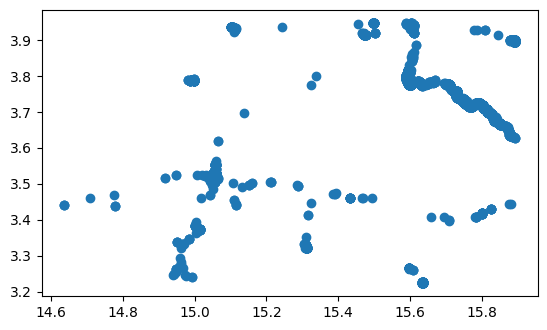

In [ ]:
ndvi_loss.plot()

In [ ]:
# Load village file
village = gpd.read_file('osm_rd_congo_localities.geojson')

print(village)


         thematic           mkey osmtype      osm_id       lat        lon  \
0      Localities  place=village       n  1156621821  0.923583  25.210667   
1      Localities  place=village       n  4230670217 -2.947820  28.956483   
2      Localities  place=village       n  1157428815 -3.993259  28.871112   
3      Localities  place=village       n  4516792720  3.160159  18.792364   
4      Localities  place=village       n  1161062328 -4.905083  17.030333   
...           ...            ...     ...         ...       ...        ...   
19894  Localities  place=village       n  1157406247 -2.871382  27.185636   
19895  Localities  place=village       n  1732085190  0.301274  21.226576   
19896  Localities  place=village       n  1157862220  2.251750  30.146556   
19897  Localities  place=village       n  5071048243 -5.937222  22.639167   
19898  Localities   place=hamlet       n  4887766298 -6.249672  28.421969   

         place abandoned:place         name  \
0      village            No

<Axes: >

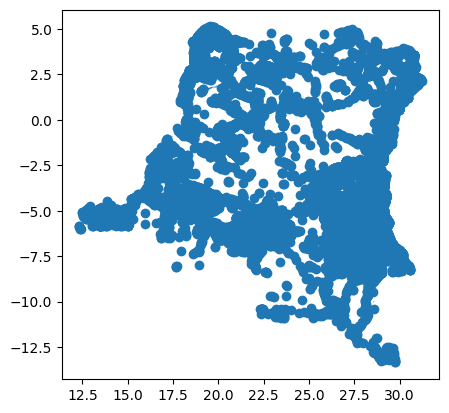

In [ ]:
village.plot()

In [ ]:
###Local road

import os
import geopandas as gpd

# Set the GDAL environment variable to restore SHX
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

data = gpd.read_file('local_roads.shp')
print(data.head())



                                            geometry
0  LINESTRING (30.85339 2.89730, 30.85343 2.89729...
1  LINESTRING (30.31317 2.93107, 30.31320 2.93088...
2  LINESTRING (15.30274 -4.30212, 15.30240 -4.302...
3  LINESTRING (16.11650 -5.77267, 16.11655 -5.772...
4  LINESTRING (28.81762 -2.93274, 28.81781 -2.932...


<Axes: >

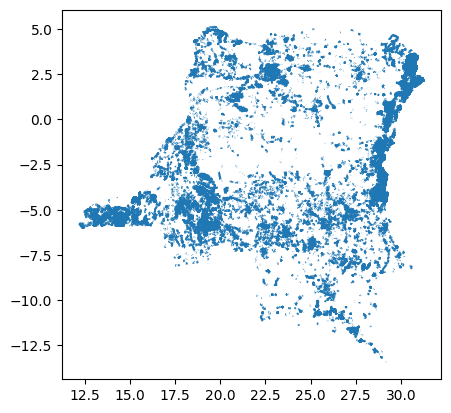

In [ ]:
%matplotlib inline
data.plot()